# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.2 MB 3.2 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

# Visualize Data

In [3]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [4]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [5]:
images[0]

'havanese_153.jpg'

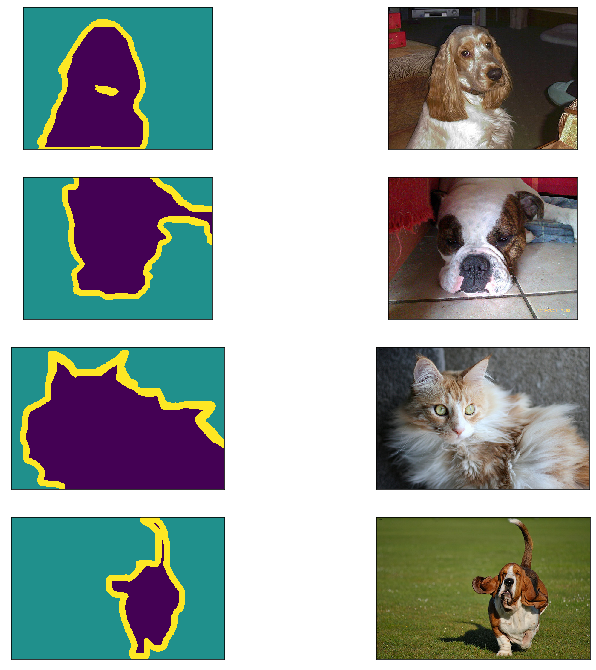

In [6]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [7]:
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [13]:
role = sagemaker.get_execution_role()
bucket_name = 'petsdatasemantic'
training_image = get_image_uri(boto3.Session().region_name,'semantic-segmentation',repo_version='latest')
print(training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


825641698319.dkr.ecr.us-east-2.amazonaws.com/semantic-segmentation:latest


In [9]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [10]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:03<00:00, 1976.13it/s]


In [11]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [12]:
print(len(train_annots), len(train_images))

5561 5561


# Uploading Data to S3

In [ ]:
sess = sagemaker.Session()
s3_train_path= sess.upload_data(path='train', bucket = bucket_name, key_prefix = 'train')
s3_train_annotation_path= sess.upload_data(path='train_annotation', bucket = bucket_name, key_prefix = 'train_annotation')
s3_validation_path= sess.upload_data(path='validation', bucket = bucket_name, key_prefix = 'validation')
s3_validation_annotation_path= sess.upload_data(path='validation_annotation', bucket = bucket_name, key_prefix = 'validation_annotation')


# SageMaker Estimator

In [42]:
model = sagemaker.estimator.Estimator(
	
    training_image,
    role=role,
    train_instance_count = 1,
    train_instance_type = 'ml.m4.xlarge',# 'ml.p3.2xlarge', #19GB GPU
    train_volume_size = 100, #100GB
    train_max_run = 36000, #seconds
    input_mode = 'File',
    output_path = 's3://petsdatasemantic/output',
    sagemaker_session=sess
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


# Hyperparameters

In [30]:
model.set_hyperparameters(
	backbone = 'resnet-50',
    algorithm = 'psp',
    use_pretrained_model = True,
    crop_size = 240,
    num_classes = 4,
    epochs = 10,
    learning_rate = 0.0001,
    optimizer = 'adam',
    lr_scheduler = 'poly',
    mini_batch_size = 16,
    validation_mini_batch_size = 16,
    num_training_samples = len(train_images)
)

# Data Channels

In [31]:
train_data = sagemaker.session.s3_input(s3_train_path, distribution = 'FullyReplicated', content_type="image/jpeg",s3_data_type = "S3Prefix")
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution = 'FullyReplicated', content_type="image/jpeg",s3_data_type = "S3Prefix")
train_annotation_data = sagemaker.session.s3_input(s3_train_annotation_path, distribution = 'FullyReplicated', content_type="image/jpeg",s3_data_type = "S3Prefix")
validation_annotation_data = sagemaker.session.s3_input(s3_validation_annotation_path, distribution = 'FullyReplicated', content_type="image/jpeg",s3_data_type = "S3Prefix")


's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [35]:
data_channel = {
    'train' : train_data,
    'validation' : validation_data,
    'train_annotation' : train_annotation_data,
    'validation_annotation' : validation_annotation_data
}

In [36]:
data_channel

{'train': <sagemaker.inputs.s3_input at 0x7f6122174e10>,
 'validation': <sagemaker.inputs.s3_input at 0x7f6122174fd0>,
 'train_annotation': <sagemaker.inputs.s3_input at 0x7f6121b1a860>,
 'validation_annotation': <sagemaker.inputs.s3_input at 0x7f6121a7e978>}

# Model Training

In [45]:
model.fit(inputs = data_channel, logs = True)

# Deploy Model

In [46]:
deployed_model = model.deploy(initial_instance_count = 1, instance_type = "ml.m4.xlarge")

In [48]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)